# viz_eval.ipynb
Contains the code to visualize the evaluation results of the trained models.

### Initialise Helper Function

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import yaml
from src import cct  # Importing the cct module
import torch
from train import validate  # Importing the validate function from train.py
from timm.data import create_dataset, create_loader
from timm.utils import *


# Assuming your results_final directory is at a certain path
results_final_path = "result_final"


def construct_model_dict(results_final_path):
    model_dict = {}

    for model_folder in os.listdir(results_final_path):
        model_path = os.path.join(results_final_path, model_folder)
        args_file = os.path.join(model_path, "args.yaml")

        if os.path.isdir(model_path) and os.path.exists(args_file):
            with open(args_file, "r") as file:
                args = yaml.safe_load(file)
                model_name = args.get("model", None)
                if model_name:
                    # Map the model_name to the initialization function
                    model_init_function = getattr(cct, model_name, None)
                    if model_init_function:
                        # Initialize the model
                        model = model_init_function(
                            pretrained=False,
                            progress=False,
                            img_size=args.get("img_size", 32),
                            positional_embedding="learnable",
                            num_classes=args.get("num_classes", 10),
                        )
                        model_dict[model_folder] = model
                        print(
                            f"Model mapped successfully: {model_folder} -> {model_name}"
                        )
                    else:
                        print(
                            f"Could not map model for folder '{model_folder}': No initialization function for '{model_name}'"
                        )
                else:
                    print(
                        f"Model name not found in args.yaml for folder '{model_folder}'"
                    )

    return model_dict


def get_model_parameter_counts(modelDict):
    param_counts = {}
    for model_name, model in modelDict.items():
        param_count = sum(p.numel() for p in model.parameters())
        param_counts[model_name] = param_count
    return param_counts


def get_best_eval_top1_scores(results_dir):
    cifar10_scores = {}
    cifar100_scores = {}

    for index, model_folder in enumerate(sorted(os.listdir(results_dir))):
        model_path = os.path.join(results_dir, model_folder)
        if os.path.isdir(model_path):
            # Read args.yaml to determine the dataset
            args_file = os.path.join(model_path, "args.yaml")
            if os.path.exists(args_file):
                with open(args_file, "r") as file:
                    args = yaml.safe_load(file)
                    dataset = args.get("dataset", "")

            # Read and process summary.csv
            summary_file = os.path.join(model_path, "summary.csv")
            if os.path.exists(summary_file):
                summary_df = pd.read_csv(summary_file)
                best_score = summary_df["eval_top1"].max()

                # Print the folder and score information
                print(
                    f"Folder {index+1}: {model_folder}, Best Eval Top1 Score: {best_score}"
                )
                # Add to respective dictionary
                if dataset == "cifar10":
                    cifar10_scores[model_folder] = best_score
                elif dataset == "cifar100":
                    cifar100_scores[model_folder] = best_score

    # Sort the scores in descending order
    cifar10_scores = {
        k: v
        for k, v in sorted(
            cifar10_scores.items(), key=lambda item: item[1], reverse=True
        )
    }
    cifar100_scores = {
        k: v
        for k, v in sorted(
            cifar100_scores.items(), key=lambda item: item[1], reverse=True
        )
    }

    return cifar10_scores, cifar100_scores


def plot_scores(scores, title, param_counts):
    plt.figure(figsize=(10, 6))
    models = list(scores.keys())
    models = [model.replace("Bryan_full_", "").replace("full", "") for model in models]
    eval_top1_scores = list(scores.values())

    # Normalize parameter counts for color intensity
    max_param_count = max(param_counts.values())
    colors = [
        plt.cm.Blues(param_counts[model] / max_param_count) for model in scores.keys()
    ]

    bars = plt.bar(models, eval_top1_scores, color=colors)
    plt.xlabel("Model")
    plt.ylabel("Best Eval Top1 Score")
    plt.title(title)
    plt.xticks(rotation=90)

    # Annotate each bar with its score
    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            round(yval, 2),
            verticalalignment="bottom",
            horizontalalignment="center",
            color="black",
            fontsize=8,
        )

    plt.show()


class Args(object):
    def __init__(self, dictionary):
        for key, value in dictionary.items():
            setattr(self, key, value)
        # Set default values for potentially missing keys
        self.set_default("prefetcher", True)
        # Add other default values as needed

    def set_default(self, key, value):
        if not hasattr(self, key):
            setattr(self, key, value)


def chooseModel(modelDict):
    availableActions = {str(i + 1): k for (i, k) in enumerate(modelDict.keys())}
    nl = "\n"
    availableActionsList = [(key, val) for key, val in availableActions.items()]
    print(f"Use number keys to choose one of the models below: \n")
    print(
        f"Available Models: {nl.join(f'[{tup[0]}: {tup[1]}]' for tup in availableActionsList)}"
    )

    while True:
        userInput = input("Enter your action: ")
        if userInput not in availableActions:
            print(f"{userInput} is an invalid action. Please try again.")
        else:
            return availableActions[userInput]


def evalSingle(modelDict, results_final_path):
    print("Starting model selection...")
    model_name = chooseModel(modelDict)
    print(f"'{model_name}' selected for evaluation and visualization")

    args_file = os.path.join(results_final_path, model_name, "args.yaml")
    print(f"Reading configuration from {args_file}")

    with open(args_file, "r") as file:
        args = Args(yaml.safe_load(file))
    print("Initializing model...")
    model = modelDict.get(model_name, None)
    if model is None:
        print(f"Model '{model_name}' not found in modelDict")
        return

    device = "cuda" if torch.cuda.is_available() else "cpu"
    checkpoint_path = os.path.join(results_final_path, model_name, "model_best.pth.tar")
    print(f"Loading checkpoint from {checkpoint_path}")

    try:
        # Load model and move to device
        checkpoint = torch.load(checkpoint_path, map_location=device)
        if "state_dict" in checkpoint:
            model.load_state_dict(checkpoint["state_dict"])
        else:
            model.load_state_dict(checkpoint)
        model.to(device)
        model.eval()
        print("Model loaded successfully.")

        print(f"Initializing DataLoader for dataset: {args.dataset}...")
        dataset_eval = create_dataset(
            args.dataset,
            root=args.data_dir,
            split=args.val_split,
            is_training=False,
            batch_size=args.batch_size,
        )
        loader_eval = create_loader(
            dataset_eval,
            input_size=(3, 32, 32),
            batch_size=args.validation_batch_size_multiplier * args.batch_size,
            is_training=False,
            use_prefetcher=False,
            interpolation=args.interpolation,
            mean=args.mean,
            std=args.std,
            num_workers=args.workers,
            distributed=False,
            crop_pct=args.crop_pct,
            pin_memory=args.pin_mem,
        )
        print("Initializing loss function...")
        loss_fn = torch.nn.CrossEntropyLoss().to(device)
        print("DataLoader and loss function initialized.")

        print("Starting model evaluation...")
        model.eval()
        batch_time_m = AverageMeter()
        losses_m = AverageMeter()
        top1_m = AverageMeter()
        top5_m = AverageMeter()

        with torch.no_grad():
            for batch_idx, (input, target) in enumerate(loader_eval):
                # Move input and target to the same device as the model
                input, target = input.to(device), target.to(device)

                # Forward pass
                output = model(input)
                loss = loss_fn(output, target)
                acc1, acc5 = accuracy(output, target, topk=(1, 5))

                # Update metrics
                losses_m.update(loss.item(), input.size(0))
                top1_m.update(acc1.item(), output.size(0))
                top5_m.update(acc5.item(), output.size(0))

        eval_metrics = {"loss": losses_m.avg, "top1": top1_m.avg, "top5": top5_m.avg}
        print(f"Evaluation Metrics for {model_name}: {eval_metrics}")
        return eval_metrics
    except Exception as e:
        print(f"Error loading {model_name} with checkpoint: {checkpoint_path}")
        print(e)

## Construct model dictionary
Maps model folder name to model initialisation function using the folder name and its `args.yaml`` file.

In [2]:
modelDict = construct_model_dict(results_final_path)

Model mapped successfully: Bryan_full_cct_2_3x2_32_c100_SETok_fixed -> cct_SETok_2_3x2_32_c100
Model mapped successfully: Bryan_full_cct_6_3x1_32_c100_DynEmbed -> cct_DynEmbed_6_3x1_32_c100
Model mapped successfully: Bryan_full_cct_6_3x1_32 -> cct_6_3x1_32
Model mapped successfully: Bryan_full_cct_2_3x2_32_DynEmbed -> cct_DynEmbed_2_3x2_32
Model mapped successfully: Bryan_full_cct_2_3x2_32_c100_DynEmbed_TempScaleAttn -> cct_DynEmbedTempScaleAttn_2_3x2_32_c100
Model mapped successfully: Bryan_full_cct_6_3x1_32_c100_DynEmbed_TempScaleAttn -> cct_DynEmbedTempScaleAttn_6_3x1_32
Model mapped successfully: Bryan_full_cct_6_3x1_32_DynEmbed_TempScaleAttnFactor -> cct_DynEmbedTempScaleAttnFactor_6_3x1_32
Model mapped successfully: full_cct_2_3x2_32 -> cct_2_3x2_32
Model mapped successfully: Bryan_full_cct_6_3x1_32_SETok_fixed -> cct_SETok_6_3x1_32
Model mapped successfully: Bryan_full_cct_7_3x1_32_DynEmbed_TempScaleAttn -> cct_DynEmbedTempScaleAttn_7_3x1_32
Model mapped successfully: full_cct_2

## Extract best model results from `summary.csv`` files in each folder
## Get parameter count of each model by initialising the model and counting the number of parameters

In [3]:
cifar10_scores, cifar100_scores = get_best_eval_top1_scores(results_final_path)
param_counts = get_model_parameter_counts(modelDict)

Folder 1: Bryan_full_cct_2_3x2_32_DynEmbed, Best Eval Top1 Score: 87.95
Folder 2: Bryan_full_cct_2_3x2_32_DynEmbed_TempScaleAttn, Best Eval Top1 Score: 88.18
Folder 3: Bryan_full_cct_2_3x2_32_SETok_fixed, Best Eval Top1 Score: 86.95
Folder 4: Bryan_full_cct_2_3x2_32_c100, Best Eval Top1 Score: 62.78
Folder 5: Bryan_full_cct_2_3x2_32_c100_DynEmbed, Best Eval Top1 Score: 65.59
Folder 6: Bryan_full_cct_2_3x2_32_c100_DynEmbed_TempScaleAttn, Best Eval Top1 Score: 65.67
Folder 8: Bryan_full_cct_2_3x2_32_c100_SETok_fixed, Best Eval Top1 Score: 62.15
Folder 9: Bryan_full_cct_6_3x1_32, Best Eval Top1 Score: 95.38
Folder 10: Bryan_full_cct_6_3x1_32_DynEmbed, Best Eval Top1 Score: 95.47
Folder 11: Bryan_full_cct_6_3x1_32_DynEmbed_TempScaleAttnFactor, Best Eval Top1 Score: 93.76
Folder 12: Bryan_full_cct_6_3x1_32_SETok_fixed, Best Eval Top1 Score: 95.08
Folder 13: Bryan_full_cct_6_3x1_32_c100, Best Eval Top1 Score: 80.27
Folder 14: Bryan_full_cct_6_3x1_32_c100_DynEmbed, Best Eval Top1 Score: 80.5


## Plot results for CIFAR10 and CIFAR100; darker shades have higher parameter count

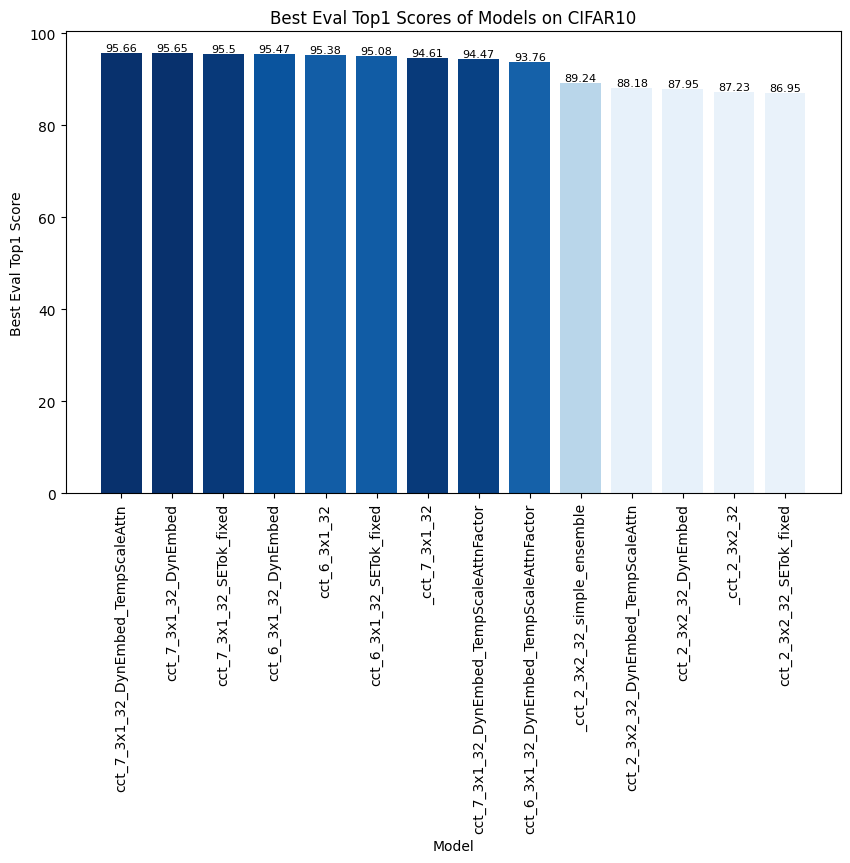

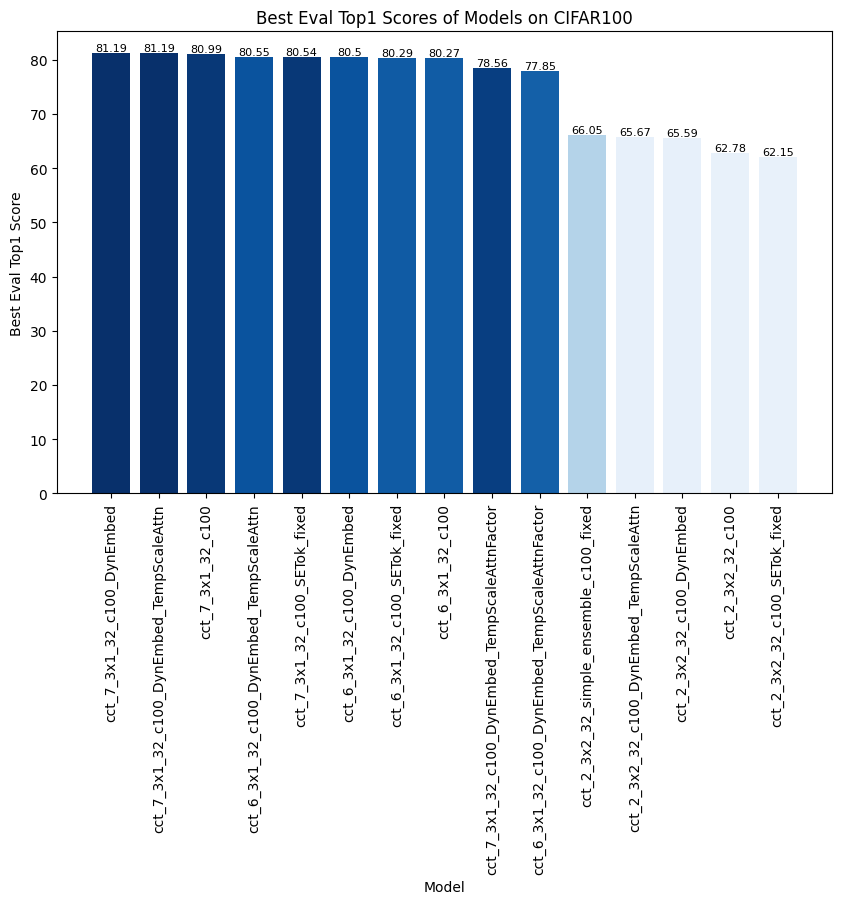

In [4]:
# Plot for CIFAR10
plot_scores(cifar10_scores, "Best Eval Top1 Scores of Models on CIFAR10", param_counts)

# Plot for CIFAR100
plot_scores(cifar100_scores, "Best Eval Top1 Scores of Models on CIFAR100", param_counts)

In [5]:
def get_model_scores_per_family(scores, dset="cifar10"):
    model_families = {}
    str_to_find = "_32_"
    if dset == "cifar100":
        str_to_find = "_c100_"
    
    for model_name, model_score in scores.items():
        model_family = "Original"
        model_key = model_name
        
        ind = model_name.find(str_to_find)
        if ind != -1:
            model_family = model_name[ind+len(str_to_find):]
            model_key = model_name[:ind+len(str_to_find)-1]
    
        if model_family not in model_families:
            model_families[model_family] = {}
        model_families[model_family][model_key] = model_score
        
    return model_families


def plot_model_family_scores(scores, title, param_counts, family):
    plt.figure(figsize=(6, 4))
    models = list(scores.keys())
    models = [model.replace("Bryan_full_", "").replace("full", "") for model in models]
    eval_top1_scores = list(scores.values())

    # Normalize parameter counts for color intensity
    max_param_count = max(param_counts.values())
    
    if family != "Original":
        family = f"_{family}"
    else:
        family = ""
    
    colors = [
        plt.cm.Blues(param_counts[f"{model}{family}"] / max_param_count) for model in scores.keys()
    ]

    bars = plt.bar(models, eval_top1_scores, color=colors)
    plt.xlabel("Model")
    plt.ylabel("Best Eval Top1 Score")
    plt.title(title)
    # plt.xticks(rotation=90)

    # Annotate each bar with its score
    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            round(yval, 2),
            verticalalignment="bottom",
            horizontalalignment="center",
            color="black",
            fontsize=8,
        )

    plt.show()


In [6]:
cifar10_scores_perfamily = get_model_scores_per_family(cifar10_scores, dset="cifar10")
cifar100_scores_perfamily = get_model_scores_per_family(cifar100_scores, dset="cifar100")

In [7]:
cifar10_scores_perfamily

{'DynEmbed_TempScaleAttn': {'Bryan_full_cct_7_3x1_32': 95.66,
  'Bryan_full_cct_2_3x2_32': 88.18},
 'DynEmbed': {'Bryan_full_cct_7_3x1_32': 95.65,
  'Bryan_full_cct_6_3x1_32': 95.47,
  'Bryan_full_cct_2_3x2_32': 87.95},
 'SETok_fixed': {'Bryan_full_cct_7_3x1_32': 95.5,
  'Bryan_full_cct_6_3x1_32': 95.08,
  'Bryan_full_cct_2_3x2_32': 86.95},
 'Original': {'Bryan_full_cct_6_3x1_32': 95.38,
  'full_cct_7_3x1_32': 94.61,
  'full_cct_2_3x2_32': 87.23},
 'DynEmbed_TempScaleAttnFactor': {'Bryan_full_cct_7_3x1_32': 94.47,
  'Bryan_full_cct_6_3x1_32': 93.76},
 'simple_ensemble': {'full_cct_2_3x2_32': 89.24}}

In [8]:
cifar100_scores_perfamily

{'DynEmbed': {'Bryan_full_cct_7_3x1_32_c100': 81.19,
  'Bryan_full_cct_6_3x1_32_c100': 80.5,
  'Bryan_full_cct_2_3x2_32_c100': 65.59},
 'DynEmbed_TempScaleAttn': {'Bryan_full_cct_7_3x1_32_c100': 81.19,
  'Bryan_full_cct_6_3x1_32_c100': 80.55,
  'Bryan_full_cct_2_3x2_32_c100': 65.67},
 'Original': {'Bryan_full_cct_7_3x1_32_c100': 80.99,
  'Bryan_full_cct_6_3x1_32_c100': 80.27,
  'Bryan_full_cct_2_3x2_32_c100': 62.78},
 'SETok_fixed': {'Bryan_full_cct_7_3x1_32_c100': 80.54,
  'Bryan_full_cct_6_3x1_32_c100': 80.29,
  'Bryan_full_cct_2_3x2_32_c100': 62.15},
 'DynEmbed_TempScaleAttnFactor': {'Bryan_full_cct_7_3x1_32_c100': 78.56,
  'Bryan_full_cct_6_3x1_32_c100': 77.85},
 'fixed': {'cct_2_3x2_32_simple_ensemble_c100': 66.05}}

### Plot results for CIFAR10 per model family

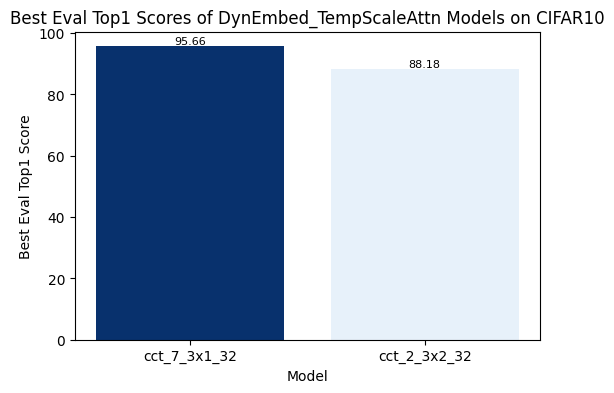

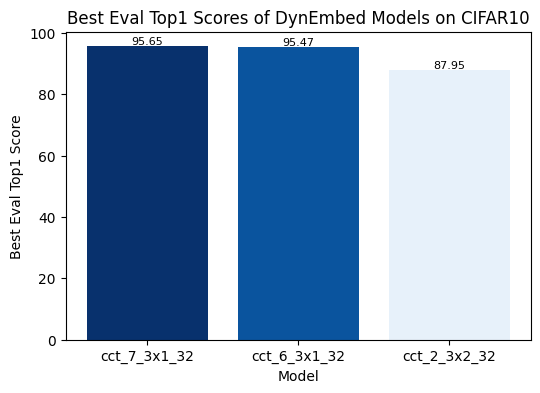

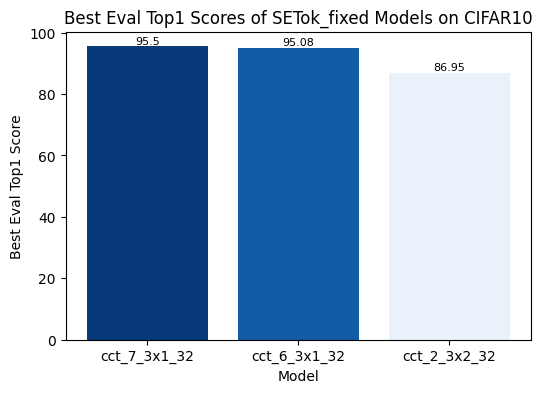

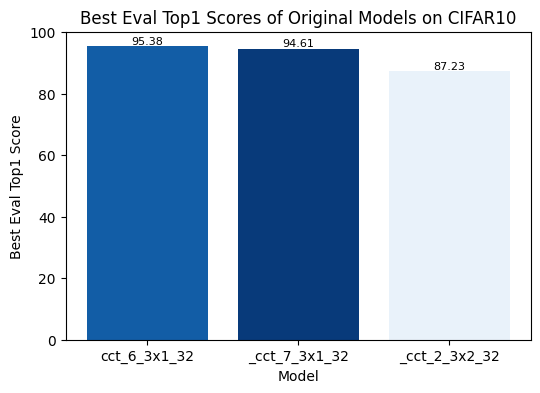

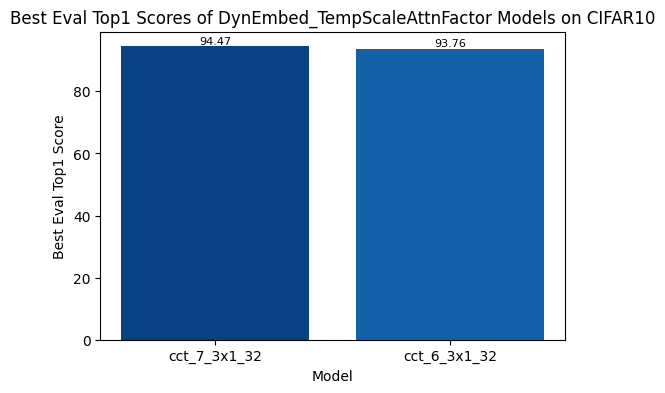

In [9]:
## Plotting for CIFAR10

for model_family, model_scores in cifar10_scores_perfamily.items():
    
    # skipping the simple ensemble model as there is only one model of that family
    if model_family == 'simple_ensemble':
        continue
    
    plot_model_family_scores(model_scores, f"Best Eval Top1 Scores of {model_family} Models on CIFAR10", param_counts, model_family)


### Plot results for CIFAR100 per model family

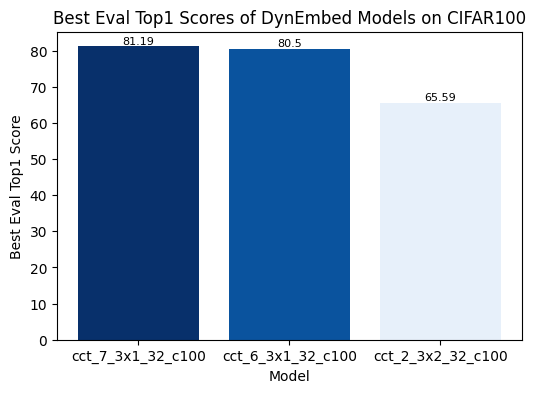

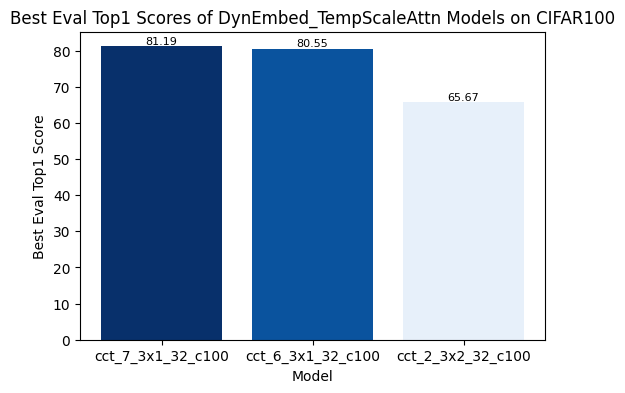

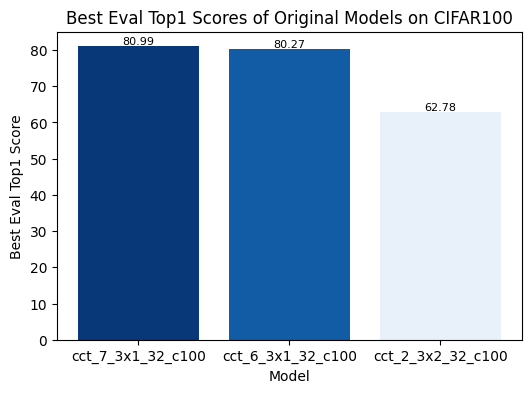

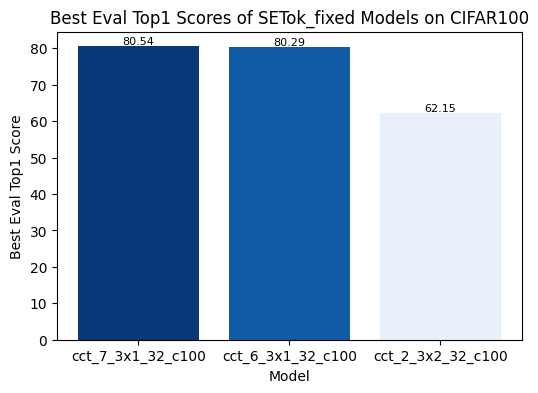

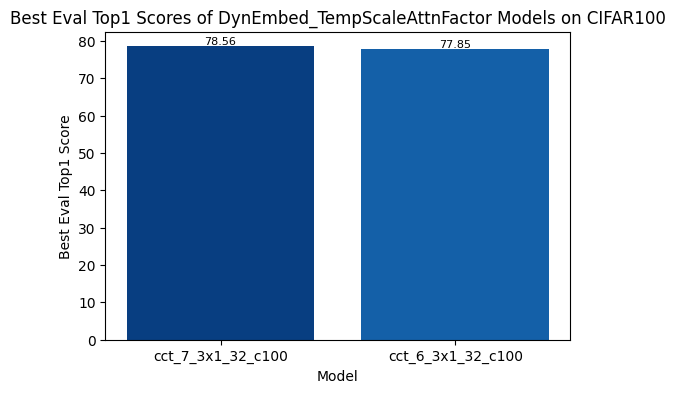

In [10]:
## Plotting for CIFAR100

for model_family, model_scores in cifar100_scores_perfamily.items():

    # skipping the simple_ensemble model
    if model_family == 'fixed':
        continue  
        
    plot_model_family_scores(model_scores, f"Best Eval Top1 Scores of {model_family} Models on CIFAR100", param_counts, model_family)

# Choose one of the models to initialise and evaluate; enter a number from 1-30 when prompted to choose a model
Loads the model from the folder name and initialises it with the arguments in the `args.yaml` file.

In [6]:
evalSingle(modelDict, results_final_path)

Starting model selection...
Use number keys to choose one of the models below: 

Available Models: [1: Bryan_full_cct_7_3x1_32_c100_DynEmbed]
[2: Bryan_full_cct_7_3x1_32_c100_SETok_fixed]
[3: Bryan_full_cct_7_3x1_32_c100_DynEmbed_TempScaleAttnFactor]
[4: Bryan_full_cct_2_3x2_32_DynEmbed_TempScaleAttn]
[5: Bryan_full_cct_7_3x1_32_DynEmbed]
[6: full_cct_7_3x1_32]
[7: Bryan_full_cct_2_3x2_32_c100_DynEmbed]
[8: Bryan_full_cct_6_3x1_32_DynEmbed]
[9: Bryan_full_cct_7_3x1_32_DynEmbed_TempScaleAttnFactor]
[10: Bryan_full_cct_6_3x1_32]
[11: Bryan_full_cct_7_3x1_32_c100_DynEmbed_TempScaleAttn]
[12: Bryan_full_cct_2_3x2_32_c100_SETok_fixed]
[13: Bryan_full_cct_2_3x2_32_c100_DynEmbed_TempScaleAttnFactor]
[14: cct_2_3x2_32_simple_ensemble_c100_fixed]
[15: Bryan_full_cct_6_3x1_32_c100_DynEmbed_TempScaleAttnFactor]
[16: Bryan_full_cct_6_3x1_32_DynEmbed_TempScaleAttnFactor]
[17: Bryan_full_cct_2_3x2_32_c100_DynEmbed_TempScaleAttn]
[18: Bryan_full_cct_2_3x2_32_c100]
[19: Bryan_full_cct_7_3x1_32_DynEmbe

{'loss': 0.2974902637720108, 'top1': 95.65, 'top5': 99.75}

In [ ]:
def evalSingleLoRA(modelDict, results_final_path):
    print("Starting model selection...")
    model_name = chooseModel(modelDict)
    print(f"'{model_name}' selected for evaluation and visualization")

    args_file = os.path.join(results_final_path, model_name, "args.yaml")
    print(f"Reading configuration from {args_file}")

    with open(args_file, "r") as file:
        args = Args(yaml.safe_load(file))
    print("Initializing model...")
    model = modelDict.get(model_name, None)
    if model is None:
        print(f"Model '{model_name}' not found in modelDict")
        return

    device = "cuda" if torch.cuda.is_available() else "cpu"
    checkpoint_path = os.path.join(results_final_path, model_name, "model_best.pth.tar")
    print(f"Loading checkpoint from {checkpoint_path}")

    try:
        # Load model and move to device
        checkpoint = torch.load(checkpoint_path, map_location=device)
        if "state_dict" in checkpoint:
            model.load_state_dict(checkpoint["state_dict"])
        else:
            model.load_state_dict(checkpoint)
        model.to(device)
        model.eval()
        print("Model loaded successfully.")

        print(f"Initializing DataLoader for dataset: {args.dataset}...")
        dataset_eval = create_dataset(
            args.dataset,
            root=args.data_dir,
            split=args.val_split,
            is_training=False,
            batch_size=args.batch_size,
        )
        loader_eval = create_loader(
            dataset_eval,
            input_size=(3, 32, 32),
            batch_size=args.validation_batch_size_multiplier * args.batch_size,
            is_training=False,
            use_prefetcher=False,
            interpolation=args.interpolation,
            mean=args.mean,
            std=args.std,
            num_workers=args.workers,
            distributed=False,
            crop_pct=args.crop_pct,
            pin_memory=args.pin_mem,
        )
        print("Initializing loss function...")
        loss_fn = torch.nn.CrossEntropyLoss().to(device)
        print("DataLoader and loss function initialized.")

        print("Starting model evaluation...")
        model.eval()
        batch_time_m = AverageMeter()
        losses_m = AverageMeter()
        top1_m = AverageMeter()
        top5_m = AverageMeter()

        with torch.no_grad():
            for batch_idx, (input, target) in enumerate(loader_eval):
                # Move input and target to the same device as the model
                input, target = input.to(device), target.to(device)

                # Forward pass
                output = model(input)
                loss = loss_fn(output, target)
                acc1, acc5 = accuracy(output, target, topk=(1, 5))

                # Update metrics
                losses_m.update(loss.item(), input.size(0))
                top1_m.update(acc1.item(), output.size(0))
                top5_m.update(acc5.item(), output.size(0))

        eval_metrics = {"loss": losses_m.avg, "top1": top1_m.avg, "top5": top5_m.avg}
        print(f"Evaluation Metrics for {model_name}: {eval_metrics}")
        return eval_metrics
    except Exception as e:
        print(f"Error loading {model_name} with checkpoint: {checkpoint_path}")
        print(e)

In [ ]:
evalSingleLoRA(modelDict, results_final_path)